**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 6
## Dimensionality Reduction and Face Recognition

In this tutorial you will use linear and non-linear dimensionality reduction on face images, and then train a classifier for face recognition. In the second part, you will then use dimensionality reduction for de-noising.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')

## 1. Loading Data and Pre-processing
We first need to load the images.  Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data.astype('float')
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


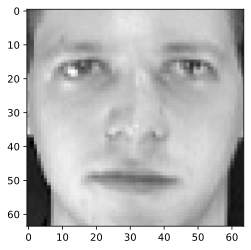

In [3]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

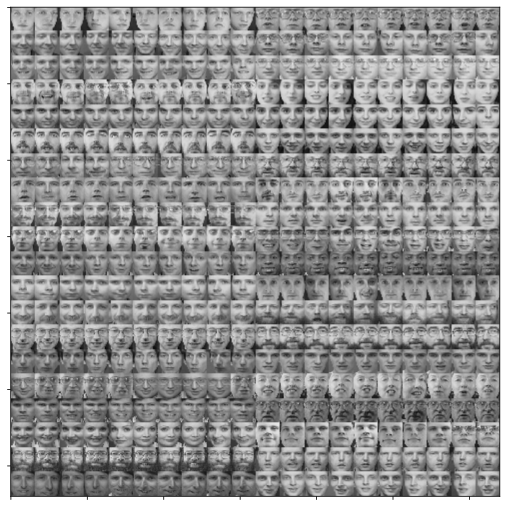

In [4]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [5]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


# 2. Linear Dimensionality Reduction - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [6]:
# fit_transform(), then transform()
pca = decomposition.PCA(n_components=9)
Wtrain = pca.fit_transform(trainX)
Wtest = pca.transform(testX)

The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [7]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = int(ceil(K/5.0))
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

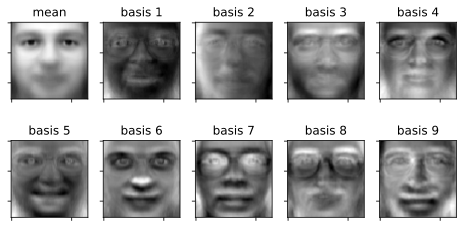

In [8]:
# run the function
plot_basis(pca, imgsize)

### What do the basis images look like? Do some basis images correspond to particular facial features?
The basis images look like abstract painting with outlandish facial features. Yes, different basis images focue on different face features (white pixels around a specific area or has a clear shape).

- Basis images 1, 4, 5 focus on the eyes area;
- Basis images 6, 7, 9 focus on moustache area;
- Basis images 3, 8 focus on eyebrow area;
- Basis images 7, 8, 9 focus on eye glasses area;
- Basis images 6 focuses on the nose tip area;

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  _You do not need to do cross-validation for the number of components._  Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

In [13]:
# Linear model

import numpy as np
paramgrid = {'C': np.logspace(-1 , 4, 20)}

lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                    paramgrid, cv=5, n_jobs=-1)
lrcv.fit(Wtrain, trainY)

predY = lrcv.predict(Wtest)

train_acc = metrics.accuracy_score(trainY, lrcv.predict(Wtrain))
test_acc = metrics.accuracy_score(testY, predY)

print("train accuracy=", train_acc)
print("test accuracy=", test_acc)

train accuracy= 0.99375
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 23.357214690901213}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 2.0691380811147893}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 10000.0}
test accuracy= 0.2625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 12.742749857031335}
test accuracy= 0.375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 3.79269019073225}
test accuracy= 0.575


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 3.79269019073225}
test accuracy= 0.65


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 2.0691380811147893}
test accuracy= 0.675


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 1.1288378916846888}
test accuracy= 0.725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 6.951927961775605}
test accuracy= 0.7875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 1.1288378916846888}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 2.0691380811147893}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 1.1288378916846888}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 0.6158482110660264}
test accuracy= 0.9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 1.1288378916846888}
test accuracy= 0.9
Dimension = 14
Best C = {'C': 2.0691380811147893}
test accuracy= 0.9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


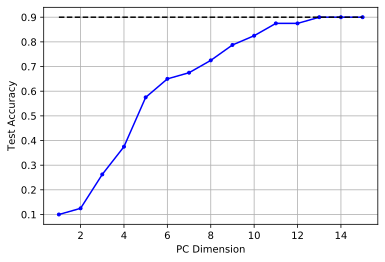

In [19]:
# Test 1~15 PCs
Xdim = 15
acc = zeros(Xdim)
paramgrid = {'C': np.logspace(-1 , 4, 20)}

for j in range(Xdim):

    pca = decomposition.PCA(n_components = j+1)
    Wnewtrain = pca.fit_transform(trainX)
    Wnewtest  = pca.transform(testX)
    
    lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                        paramgrid, cv=5, n_jobs=-1)
    lrcv.fit(Wnewtrain, trainY)

    predY = lrcv.predict(Wnewtest)
    acc[j] = metrics.accuracy_score(testY, predY)

    print("Dimension =", j)
    print("Best C =", lrcv.best_params_)
    print("test accuracy=", acc[j])    

# make a plot
plt.plot(range(1,Xdim+1), acc, '.b-') 
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--') 
plt.grid(True)
plt.xlabel('PC Dimension')
plt.ylabel('Test Accuracy');

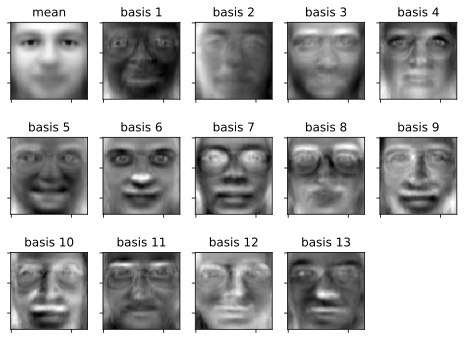

In [23]:
# Visualize the basis images (use the best number of components according to the above plots)
npc = 13
pca = decomposition.PCA(n_components=npc)
pca.fit_transform(trainX)
plot_basis(pca, imgsize)

### What is the best number of components?  View the basis images to see what they look like
- The best number of PC is 13 with test accuracy = 0.9 (the test accuracy will not increase when more PCs are allowed);
- The basis images look similar to the basis images above (when n_components=9). The basis images 10\~13 tends to describe the human face in a more specific manner.

# 3. Linear Dimensionality Reduction - NMF
Now we will repeat the experiment using non-negative matrix factorization instead of PCA.  Perform NMF with 9 components and visualize the basis images.

In [25]:
nmf = decomposition.NMF(n_components=9) 
Wnmftrain = nmf.fit_transform(trainX)
Wnmftest = nmf.transform(testX)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


### View basis images

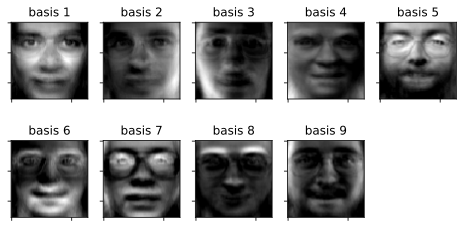

In [26]:
plot_basis(nmf, imgsize)

### What do the basis images look like?  What is the main difference with the PCA basis images?
- The basis images output by NMF are more clear than the PCA's (human faces are blur in PCA's basis images).
- The basis images output by NMF are much darker than PCA's (there are more white/gray area in PCA's basis images).
- The basis images output by NMF seem to have stronger interests on different facial areas than the PCA's.
- The basis images output by NMF look more like reasonable human faces than the PCA's.

### Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

Dimension = 0
Best C = {'C': 10000.0}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 1
Best C = {'C': 483.2930238571752}
test accuracy= 0.1375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 2
Best C = {'C': 10000.0}
test accuracy= 0.1875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 3
Best C = {'C': 1623.776739188721}
test accuracy= 0.4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 4
Best C = {'C': 483.2930238571752}
test accuracy= 0.525


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 5
Best C = {'C': 263.6650898730358}
test accuracy= 0.5875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 6
Best C = {'C': 263.6650898730358}
test accuracy= 0.6875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 7
Best C = {'C': 143.8449888287663}
test accuracy= 0.75


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 8
Best C = {'C': 143.8449888287663}
test accuracy= 0.75


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 9
Best C = {'C': 885.8667904100823}
test accuracy= 0.7875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 10
Best C = {'C': 263.6650898730358}
test accuracy= 0.8125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 11
Best C = {'C': 78.47599703514607}
test accuracy= 0.8375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 12
Best C = {'C': 23.357214690901213}
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 

Dimension = 13
Best C = {'C': 23.357214690901213}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Dimension = 14
Best C = {'C': 483.2930238571752}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


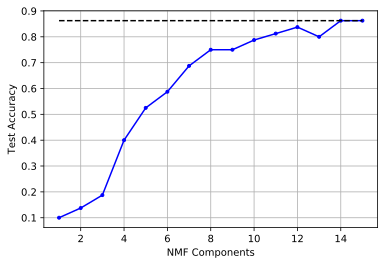

In [28]:
# Test 1~15 NMF Components
Xdim = 15
acc = zeros(Xdim)
paramgrid = {'C': np.logspace(-1 , 4, 20)}

for j in range(Xdim):

    nmf = decomposition.NMF(n_components=j+1)
    Wnewtrain = nmf.fit_transform(trainX)
    Wnewtest = nmf.transform(testX)
    
    lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                        paramgrid, cv=5, n_jobs=-1)
    lrcv.fit(Wnewtrain, trainY)

    predY = lrcv.predict(Wnewtest)
    acc[j] = metrics.accuracy_score(testY, predY)

    print("Dimension =", j)
    print("Best C =", lrcv.best_params_)
    print("test accuracy=", acc[j])    

# make a plot
plt.plot(range(1,Xdim+1), acc, '.b-') 
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--') 
plt.grid(True)
plt.xlabel('NMF Components')
plt.ylabel('Test Accuracy');

### Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is NMF or PCA better?
- The best number of component is 14 with test accuracy = 0.8625 (the test accuracy will not increase when more PCs are allowed);

- The best accuracy of NMF method is 0.8625 while the PCA method can achieve accuracy = 0.9;

- The PCA method is better. Because the PCA method finds a subspace which conserves the variance of the data, while NMF only finds the non-negative features (negative feature values in PCA might help the classifier to draw a conclusion that one image does not belong to a specific class).

# Non-Linear Dimensionality Reduction - KPCA
Now we will use KPCA to perform non-linear dimensionality reduction on the data  before training the classifier.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [30]:
# KPCA: 10 principal components, RBF kernel, gamma=0.001.
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
Wtrain = kpca.fit_transform(trainX)
Wtest = kpca.transform(testX)

In [36]:
def trainresult(Wtrain, Wtest, g, ker):
    Xdim = 15
    acc = zeros(Xdim)
    paramgrid = {'C': np.logspace(-1 , 4, 20)}
    
    for j in range(Xdim):
        
        kpca = decomposition.KernelPCA(n_components=j+1, kernel=ker, gamma=g)
        Wnew = kpca.fit_transform(trainX)
        Wnewtest = kpca.transform(testX)
    
        lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                            paramgrid, cv=5, n_jobs=-1)
        lrcv.fit(Wnew, trainY)

        predY = lrcv.predict(Wnewtest)
        acc[j] = metrics.accuracy_score(testY, predY)

        print("Dimension =", j)
        print("Best C =", lrcv.best_params_)
        print("test accuracy=", acc[j])    

    # make a plot
    plt.plot(range(1,Xdim+1), acc, '.b-') 
    plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--') 
    plt.grid(True)
    plt.xlabel('Number of PC')
    plt.ylabel('Classification Accuracy');

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [32]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

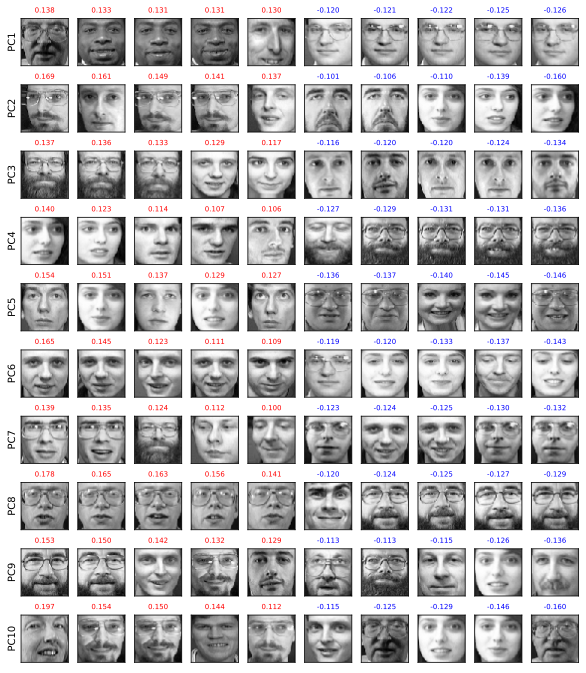

In [33]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

### What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?
- The KPCA basis try to model the differences between the facial images from different persons (so as to separate them);
- PC1 might try to distinguish faces according to different skin colors;
- PC2 might try to distinguish faces according to the face direction;
- PC3 not sure
- PC4 might try to distinguish faces according to the beard;
- PC5 might try to distinguish faces according to the shape of nose;
- PC6 might try to distinguish faces according to the eyesight direction;
- PC7 not sure
- PC8 might try to distinguish faces according to the beard for people wearing eye glasses;
- PC9 not sure
- PC10 not sure (high-dim features are difficult to interpret)

### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

### RBF kernel

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 2976.351441631319}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 1623.776739188721}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 10000.0}
test accuracy= 0.2875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 2976.351441631319}
test accuracy= 0.4125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 10000.0}
test accuracy= 0.5875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 1623.776739188721}
test accuracy= 0.6375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 885.8667904100823}
test accuracy= 0.7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 1623.776739188721}
test accuracy= 0.775


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 2976.351441631319}
test accuracy= 0.8125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 483.2930238571752}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 2976.351441631319}
test accuracy= 0.8375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 5455.594781168515}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 885.8667904100823}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 263.6650898730358}
test accuracy= 0.8625
Dimension = 14
Best C = {'C': 483.2930238571752}
test accuracy= 0.8875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


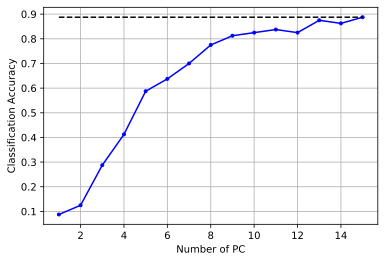

In [37]:
# KPCA: 1~15 PCs, RBF kernel, gamma=0.001.
trainresult(Wtrain, Wtest, 0.001, 'rbf')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 5455.594781168515}
test accuracy= 0.1125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 483.2930238571752}
test accuracy= 0.1375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 885.8667904100823}
test accuracy= 0.2375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 885.8667904100823}
test accuracy= 0.35


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 1623.776739188721}
test accuracy= 0.525


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 263.6650898730358}
test accuracy= 0.65


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 2976.351441631319}
test accuracy= 0.7375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 5455.594781168515}
test accuracy= 0.775


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 78.47599703514607}
test accuracy= 0.725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 263.6650898730358}
test accuracy= 0.7875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 885.8667904100823}
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 263.6650898730358}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 263.6650898730358}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 143.8449888287663}
test accuracy= 0.8875
Dimension = 14
Best C = {'C': 263.6650898730358}
test accuracy= 0.9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


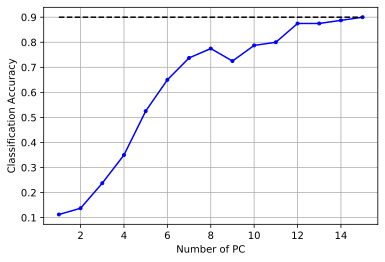

In [43]:
# KPCA: 1~15 PCs, RBF kernel, gamma=0.05.
trainresult(Wtrain, Wtest, 0.005, 'rbf')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 483.2930238571752}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 885.8667904100823}
test accuracy= 0.1125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 2976.351441631319}
test accuracy= 0.2625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 2976.351441631319}
test accuracy= 0.45


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 2976.351441631319}
test accuracy= 0.625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 885.8667904100823}
test accuracy= 0.6875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 483.2930238571752}
test accuracy= 0.75


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 1623.776739188721}
test accuracy= 0.775


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 885.8667904100823}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 885.8667904100823}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 2976.351441631319}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 143.8449888287663}
test accuracy= 0.85


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 143.8449888287663}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 483.2930238571752}
test accuracy= 0.8625
Dimension = 14
Best C = {'C': 1623.776739188721}
test accuracy= 0.9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


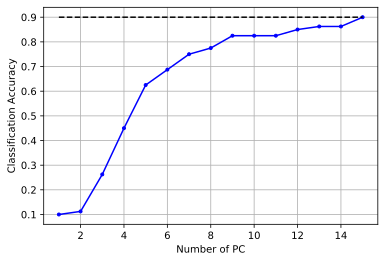

In [38]:
# KPCA: 1~15 PCs, RBF kernel, gamma=0.01.
trainresult(Wtrain, Wtest, 0.01, 'rbf')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 1623.776739188721}
test accuracy= 0.025


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 10000.0}
test accuracy= 0.0375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 10000.0}
test accuracy= 0.0375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 10000.0}
test accuracy= 0.05


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 10000.0}
test accuracy= 0.0625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 10000.0}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 10000.0}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 10000.0}
test accuracy= 0.1125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 2976.351441631319}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 10000.0}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 10000.0}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 5455.594781168515}
test accuracy= 0.1375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 10000.0}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 10000.0}
test accuracy= 0.125
Dimension = 14
Best C = {'C': 10000.0}
test accuracy= 0.15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


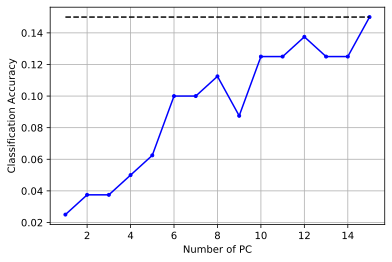

In [39]:
# KPCA: 1~15 PCs, RBF kernel, gamma=0.1.
trainresult(Wtrain, Wtest, 0.1, 'rbf')

### Poly kernel

Dimension = 0
Best C = {'C': 78.47599703514607}
test accuracy= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 143.8449888287663}
test accuracy= 0.125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 263.6650898730358}
test accuracy= 0.25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 263.6650898730358}
test accuracy= 0.3875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 5455.594781168515}
test accuracy= 0.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 263.6650898730358}
test accuracy= 0.675


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 78.47599703514607}
test accuracy= 0.6625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 143.8449888287663}
test accuracy= 0.7375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 483.2930238571752}
test accuracy= 0.7875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 143.8449888287663}
test accuracy= 0.825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 885.8667904100823}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 143.8449888287663}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 78.47599703514607}
test accuracy= 0.8625
Dimension = 13
Best C = {'C': 42.81332398719391}
test accuracy= 0.875
Dimension = 14
Best C = {'C': 42.81332398719391}
test accuracy= 0.875


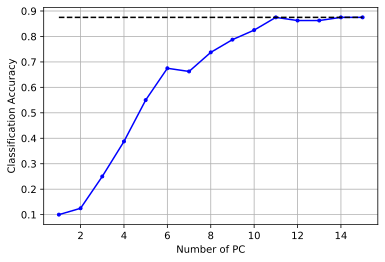

In [40]:
# KPCA: 1~15 PCs, Poly kernel, gamma=0.001.
trainresult(Wtrain, Wtest, 0.001, 'poly')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 42.81332398719391}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 263.6650898730358}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 1623.776739188721}
test accuracy= 0.2125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 6.951927961775605}
test accuracy= 0.35


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 23.357214690901213}
test accuracy= 0.5375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 0.6158482110660264}
test accuracy= 0.625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 0.18329807108324356}
test accuracy= 0.6375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 0.33598182862837817}
test accuracy= 0.7125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 0.6158482110660264}
test accuracy= 0.7875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 0.18329807108324356}
test accuracy= 0.775


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 0.33598182862837817}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 1.1288378916846888}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 0.33598182862837817}
test accuracy= 0.85


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 0.1}
test accuracy= 0.85
Dimension = 14
Best C = {'C': 0.18329807108324356}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


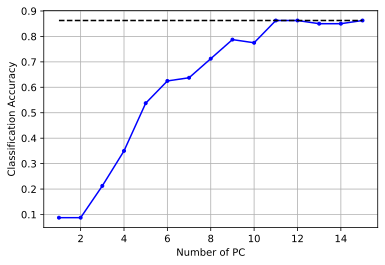

In [41]:
# KPCA: 1~15 PCs, Poly kernel, gamma=0.01.
trainresult(Wtrain, Wtest, 0.01, 'poly')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 0.6158482110660264}
test accuracy= 0.075


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 6.951927961775605}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 0.18329807108324356}
test accuracy= 0.2125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 3.79269019073225}
test accuracy= 0.3375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 263.6650898730358}
test accuracy= 0.5625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 0.1}
test accuracy= 0.6125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 0.1}
test accuracy= 0.65


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 0.1}
test accuracy= 0.725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 0.1}
test accuracy= 0.725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 143.8449888287663}
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 2976.351441631319}
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 0.1}
test accuracy= 0.875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 0.1}
test accuracy= 0.85


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 0.1}
test accuracy= 0.875
Dimension = 14
Best C = {'C': 0.18329807108324356}
test accuracy= 0.9125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


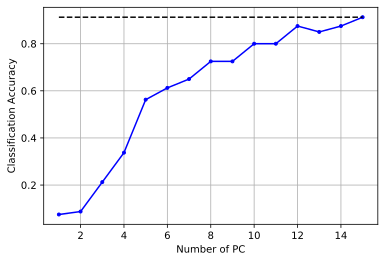

In [44]:
# KPCA: 1~15 PCs, Poly kernel, gamma=0.05.
trainresult(Wtrain, Wtest, 0.05, 'poly')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 0
Best C = {'C': 1623.776739188721}
test accuracy= 0.075


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 1
Best C = {'C': 0.1}
test accuracy= 0.0875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 2
Best C = {'C': 263.6650898730358}
test accuracy= 0.1875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 3
Best C = {'C': 0.1}
test accuracy= 0.3375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 4
Best C = {'C': 2.0691380811147893}
test accuracy= 0.5625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 5
Best C = {'C': 0.1}
test accuracy= 0.625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 6
Best C = {'C': 23.357214690901213}
test accuracy= 0.6125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 7
Best C = {'C': 0.1}
test accuracy= 0.7125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 8
Best C = {'C': 0.1}
test accuracy= 0.7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 9
Best C = {'C': 3.79269019073225}
test accuracy= 0.8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 10
Best C = {'C': 2976.351441631319}
test accuracy= 0.8125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 11
Best C = {'C': 0.1}
test accuracy= 0.8625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 12
Best C = {'C': 0.18329807108324356}
test accuracy= 0.85


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Dimension = 13
Best C = {'C': 0.1}
test accuracy= 0.8625
Dimension = 14
Best C = {'C': 0.1}
test accuracy= 0.9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


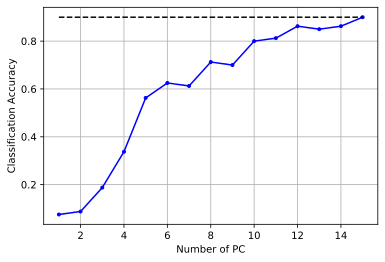

In [42]:
# KPCA: 1~15 PCs, Poly kernel, gamma=0.1.
trainresult(Wtrain, Wtest, 0.1, 'poly')

### What is the best kernel and number of components?
- The best accuracy I achieved is 0.9. This accuracy can be achieved by:
  - RBF kernel PCA with 14 PCs, gamma = 0.05, LR-C = 263
  - OR
  - Poly kernel PCA with 14 PCs, gamma = 0.1, LR-C = 0.1

- So, there is no 'best kernel', both RBF and Poly kernels can achieve similar performance under different parameters.


### Which dimensionality reduction method performs the best for classification? Why?
- Maybe performance: PCA > kernel PCA > NMF.
- Both PCA and kernel PCA can achieve a test accuracy of 0.9. For NMF, it achieve the highest test accuracy of only 0.86.
- However, the PCA method can use 12 PCs to achieve 0.9 accuracy while the kernel PCA needs 14 PCs. So I conclude that more features are preserved by the PCA method because it need fewer number of PCs to achieve the same classification performance.

# De-noising with dimensionality reduction

In this section, we will  use dimensionality reduction for denoising a face image. Given a noisy image $\mathbf{x}$, we first compute the low-dimensional representation $\mathbf{w}$, e.g., using PCA. Then given $\mathbf{w}$, we reconstruct the image $\hat{\mathbf{x}}$ from the PCA/NMF basis.  In sklearn, the reconstruction step can be achieved using the `inverse_transform()` method of the PCA or NMF classes.

Train a PCA or NMF model using a large number of components (e.g., 100) on the face dataset, and then test it for denoising. For the noisy images, you can try different types of noise, such as:
- additive noise (using `random.normal`)
- salt & pepper noise (using `random.binomial`)
- masking out part of the image (the masked out part can be replaced with black, gray, or white).


for evaluation of the reconstruction or denoising result you can use "peak signal to noise ratio", which is implemented in skimage as `skimage.metrics.peak_signal_noise_ratio` or `skimage.measure.compare_psnr` (on older versions).

In [45]:
import skimage

###  Add noise to images

In [66]:
# noise is sampled from normal distribution
noisyX = trainX + random.normal(size=trainX.shape)/50
noisyXt = testX + random.normal(size=testX.shape)/50

In [78]:
# noise is sampled from binomial distribution
noisyX_b = trainX + random.binomial(10, 0.5, size=trainX.shape)/50
noisyXt_b = testX + random.binomial(10, 0.5, size=testX.shape)/50

Noise is sampled from normal distribution


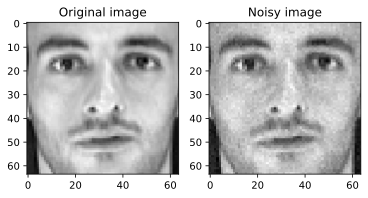

In [81]:
# Show noisy images
im = trainX[0].reshape(imgsize)
im_noisy = noisyX[0].reshape(imgsize)

print('Noise is sampled from normal distribution')
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy, cmap='gray', interpolation='nearest')
plt.title('Noisy image')
plt.show()

Noise is sampled from binomial distribution


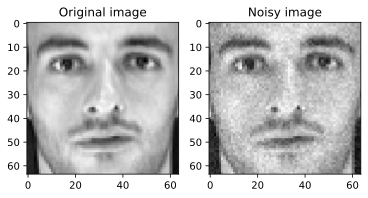

In [79]:
# Show noisy images
im = trainX[0].reshape(imgsize)
im_noisy = noisyX_b[0].reshape(imgsize)

print('Noise is sampled from binomial distribution')
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy, cmap='gray', interpolation='nearest')
plt.title('Noisy image')
plt.show()

###  Learn PCA on noisy data, use the best number of PC obtained in the previous experiment

In [68]:
pca = decomposition.PCA(n_components=12)
pca.fit(noisyX)

testW = pca.transform(noisyXt)
testXr = pca.inverse_transform(testW)

In [80]:
pca_b = decomposition.PCA(n_components=12)
pca_b.fit(noisyX_b)

testW_b = pca_b.transform(noisyXt_b)
testXr_b = pca_b.inverse_transform(testW_b)

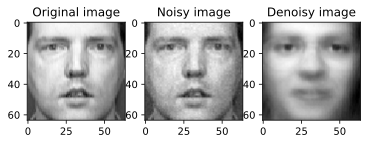

In [69]:
# Show noisy images, denoise result
im = testX[0].reshape(imgsize)
im_noisy = noisyXt[0].reshape(imgsize)
im_denoisy = testXr[0].reshape(imgsize)

print('Noise is sampled from normal distribution')
plt.subplot(1, 3, 1)
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(im_noisy, cmap='gray', interpolation='nearest')
plt.title('Noisy image')

plt.subplot(1, 3, 3)
plt.imshow(im_denoisy, cmap='gray', interpolation='nearest')
plt.title('Denoisy image')
plt.show()

Noise is sampled from binomial distribution


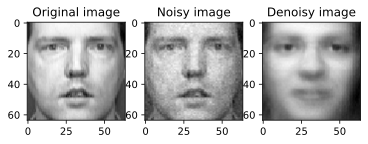

In [82]:
# Show noisy images, denoise result
im_b = testX[0].reshape(imgsize)
im_noisy_b = noisyXt_b[0].reshape(imgsize)
im_denoisy_b = testXr_b[0].reshape(imgsize)

print('Noise is sampled from binomial distribution')
plt.subplot(1, 3, 1)
plt.imshow(im_b, cmap='gray', interpolation='nearest')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(im_noisy_b, cmap='gray', interpolation='nearest')
plt.title('Noisy image')

plt.subplot(1, 3, 3)
plt.imshow(im_denoisy_b, cmap='gray', interpolation='nearest')
plt.title('Denoisy image')
plt.show()

###  Test PCA denoies performance

In [83]:
from skimage.measure import compare_psnr

print('Noise sampled from the Normal Distribution:')
print('Original image v.s. Noisy image', compare_psnr(im, im_noisy))
print('Original image v.s. De-Noisy image', compare_psnr(im, im_denoisy))

print()

print('Noise sampled from the Binomial Distribution:')
print('Original image v.s. Noisy image', compare_psnr(im_b, im_noisy_b))
print('Original image v.s. De-Noisy image', compare_psnr(im_b, im_denoisy_b))

Noise sampled from the Normal Distribution:
Original image v.s. Noisy image 33.925512101177006
Original image v.s. De-Noisy image 17.31704522584915

Noise sampled from the Binomial Distribution:
Original image v.s. Noisy image 19.564995705122243
Original image v.s. De-Noisy image 18.1948190483471


### Which kind of noise can be handled well by linear dimensionality reduction? Why?
- The noise sampled from the normal distribution is handled better since it largely reduce the reconstruction error:
  - Noise from the normal distribution: 33.9 -> 17.3
  - Noise from the binomial distribution: 19.5 -> 18.1

- The de-noise result should depends on the parameters of different distribution (i.e., the scale of nosie)

- The normal distribution is continuous while the binomial distribution is discrete.